## Initializations & imports

In [4]:
import sys
import tweepy
import json, snap, csv
import numpy as np

In [ ]:
consumer_key = 'aCqrloIHCuvw8rX8sON8B551T'
consumer_secret = 'CkkLBIClzyC2w00oHOateou4wxJ2IberPKXWR8WpQEi0T5Gh2s'
access_token = '173960222-v34xiH0gEFqXCoVvpnh3JgMp8xwVukAX61rqazBc'
access_token_secret = '9ey7wPBUkPJdu2ZxaBoOUr43dmFCj2Fql1MxBCPKEoVFg'

## Getting data from twitter

In [15]:
class StdOutListener(tweepy.StreamListener):
    
    def __init__(self):
        self.num_tweets = 0
    
    def on_status(self, status):
        try:
            #tweet_json = json.loads(json.dumps(status._json))
            #print tweet_json
            print(json.dumps(status._json))
        except:
            print("Unexpected error:", sys.exc_info()[0])
        return True
    
    def on_data(self, data):
        try:
            with open('network.json', 'a') as f:
                f.write(data) # This will store the whole JSON data in the file, you can perform some JSON filters
                self.num_tweets += 1
                print(self.num_tweets)
            if self.num_tweets < 1500:
                return True
            else:
                return False
        except BaseException as e:
            print("Error on_data: %s" % str(e))
        return True
    
    def on_error(self, status_code):
        print('Got an error with status code: ' + str(status_code))
        return False # To continue listening
    
    def on_timeout(self):
        print('Timeout...')
        return False # To continue listening
    
if __name__ == '__main__':
    listener = StdOutListener()
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    stream = tweepy.Stream(auth, listener)
    #stream.filter(locations=[-6.38,49.87,1.77,55.81])
    # coordinates of barcelona
    stream.filter(track=['grammy'])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


## Convert into pandas and then into csv

In [36]:
import pandas as pd
dfN = pd.read_csv('nodes_ment.csv')
dfE = pd.read_csv('edges_ment.csv')

In [37]:
dfN

,Id,Label,Followers,Lang
0,1036323152064860160,posexwdw,994.0,None
1,1038906616198909952,2020predicts,NaN,NaN
2,290251672,babizzao,623.0,None
3,64813772,JosyRamos,NaN,NaN
4,952145663273283585,EuphoriaAthena,275.0,None
...,...,...,...,...
32117,52748217,AlineSFCarneiro,526.0,None
32118,992531090341617666,orefejoo__,7559.0,None
32119,342336795,GeoffreyPge,138.0,None
32120,934516447686086656,queen_cece606,4.0,None


In [38]:
dfN['SeqId'] = range(1,len(dfN) + 1)
dfNsimple = dfN.drop(['Label','Followers','Lang'],axis = 1)

dfT = pd.merge(dfE, dfNsimple, left_on = 'Source', right_on = 'Id')
dfT['Source'] = dfT['SeqId']

del dfT['SeqId']
del dfT['Id']

dfEout = pd.merge(dfT, dfNsimple, left_on = 'Target', right_on = 'Id')

dfEout['Target'] = dfEout['SeqId']
del dfEout['SeqId']
del dfEout['Id']

dfEout.to_csv('edgesSeq_ment.csv', sep = ',', index = False)

## Building the graph with the generated data

In [32]:
def add_node(G, id_node):
    if not G.IsNode(id_node):
        G.AddNode(id_node)

In [40]:
graph_old = snap.TNGraph.New()

with open('edgesSeq_ment.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        source = int(row['Source'])
        target = int(row['Target'])
        
        add_node(graph_old, source)
        add_node(graph_old, target)
        graph_old.AddEdge(source, target)

snap.SaveEdgeList(graph_old, "list_edges_ment.txt", "List of edges")

## Clustering coefficient

In [42]:
def get_clust_coef(G):
    CC = snap.GetClustCf(G)
    print ("clustering coefficient", CC)

## Most central nodes

In [23]:
# Top 10 central nodes by PageRank
def get_central_nodes_PR(G):
    PRankH = snap.TIntFltH()
    snap.GetPageRank(G, PRankH)
    sorted_PRankH = sorted(PRankH, key = lambda key: PRankH[key], reverse = True)
    print("Node, PageRank score")
    for item in sorted_PRankH[0:10]:
        print (item, PRankH[item])

In [111]:
def get_central_nodes_BC(G):
    Nodes = snap.TIntFltH()
    Edges = snap.TIntPrFltH()
    snap.GetBetweennessCentr(G, Nodes, Edges, 1.0)
    sorted_BC = sorted(Nodes, key = lambda key: Nodes[key], reverse = True)
    print("Node, BC score")
    for node in sorted_BC[0:10]:
        print(node, sorted_BC[node])

## Av path length, diameter, effective diameter

In [24]:
def get_diameter(G):
    D = snap.GetBfsFullDiam(G, 7000)
    print ("diameter", D)

# Calculate effectivbig_graphmeter
def get_effective_diameter(G):
    ED = snap.GetBfsEffDiam(G, 7000) 
    print ("effective diameter", ED)

In [25]:
def get_av_path_length(G):
    NIdToDistH = snap.TIntH()
    # Node traversal
    distL=[]
    i=0
    MxSccG5 = snap.GetMxScc(G)
    numNodes=MxSccG5.GetNodes()
    dmN=np.zeros(numNodes)
    IsDir = True

    for NI in MxSccG5.Nodes():
        i += 1;
        if (i% 100) ==0:
            print ("node %d, of %d" \
            % (i, numNodes))
        shortestPath = snap.GetShortPath(MxSccG5, NI.GetId(), NIdToDistH, IsDir)
        temp=[]
        for item in NIdToDistH:
            if NIdToDistH[item] > 0:
                distL.append(NIdToDistH[item])
                temp.append(NIdToDistH[item])
        dmN[i-1]=np.mean(temp)
    return distL

## K-cores

In [107]:
def k_cores(graph):
    # Calcualte the number of nodes in every core
    CoreIDSzV = snap.TIntPrV()
    kValue = snap.GetKCoreNodes(graph, CoreIDSzV)
    for item in CoreIDSzV:
        print ("k-core: %d nodes: %d" % (item.GetVal1(), item.GetVal2()))

def num_nodes_per_core(graph):
    # Calcualte the number of nodes in every core
    CoreIDSzV = snap.TIntPrV()
    kValue = snap.GetKCoreNodes(graph, CoreIDSzV)
    for item in CoreIDSzV:
        print ("k-core: %d nodes: %d" % (item.GetVal1(), item.GetVal2()))



# Homework 3

### Problem 1

In [81]:
ment_graph = snap.LoadEdgeList(snap.PNGraph,"list_edges_ment.txt",0,1)
print(ment_graph.GetNodes())

32122


### Problem 2
Most central nodes:

In [ ]:
get_central_nodes_PR(ment_graph)
get_central_nodes_BC(ment_graph)

In [85]:
get_diameter(ment_graph)
get_effective_diameter(ment_graph)

diameter 23
effective diameter 8.774824686112789


In [105]:
print("Average path length:")
np.mean(get_av_path_length(ment_graph))

Average path length:


1.8

In [108]:
print("K-cores values:")
k_cores(ment_graph)
print("K-cores nodes per core")
num_nodes_per_core(ment_graph)

K-cores values:
k-core: 0 nodes: 32122
k-core: 1 nodes: 32122
k-core: 2 nodes: 7076
k-core: 3 nodes: 1704
k-core: 4 nodes: 383
k-core: 5 nodes: 112
k-core: 6 nodes: 31
k-core: 7 nodes: 18
K-cores nodes per core
k-core: 0 nodes: 32122
k-core: 1 nodes: 32122
k-core: 2 nodes: 7076
k-core: 3 nodes: 1704
k-core: 4 nodes: 383
k-core: 5 nodes: 112
k-core: 6 nodes: 31
k-core: 7 nodes: 18


In [88]:
get_clust_coef(ment_graph)

clustering coefficient 0.02829643465001018


### Problem 3

In [10]:
!pip install powerlaw

In [89]:
import powerlaw as pl
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt;

In [90]:
G = ment_graph

plt.rcParams['figure.figsize'] = [10, 7]
InDegV = snap.TIntPrV()
snap.GetNodeInDegV(G, InDegV)

numItemstoList=20;i=0;
for item in InDegV:
    print ("node ID %d: in-degree %d" % (item.GetVal1(), item.GetVal2()))
    i=i+1
    if i==numItemstoList:
        break # comment to output all nodes

a = np.arange(1, snap.CntNonZNodes(G) - snap.CntInDegNodes(G,0) +2)
i=0
for item in InDegV:
    if item.GetVal2() > 0 :
        i=i+1
        a[i]=item.GetVal2()

node ID 1: in-degree 0
node ID 2: in-degree 64
node ID 2313: in-degree 21
node ID 311: in-degree 0
node ID 312: in-degree 12
node ID 1139: in-degree 0
node ID 1551: in-degree 0
node ID 3689: in-degree 23
node ID 1886: in-degree 0
node ID 2626: in-degree 0
node ID 2723: in-degree 0
node ID 2988: in-degree 0
node ID 3877: in-degree 0
node ID 4400: in-degree 0
node ID 5413: in-degree 0
node ID 5486: in-degree 0
node ID 5849: in-degree 0
node ID 62: in-degree 379
node ID 193: in-degree 76
node ID 758: in-degree 37


In [91]:
bars, bins = np.histogram(a,bins=np.arange(1,max(a)))

In [92]:
bins

array([   1,    2,    3, ..., 2336, 2337, 2338])

Text(0.5, 0, 'in-degree')

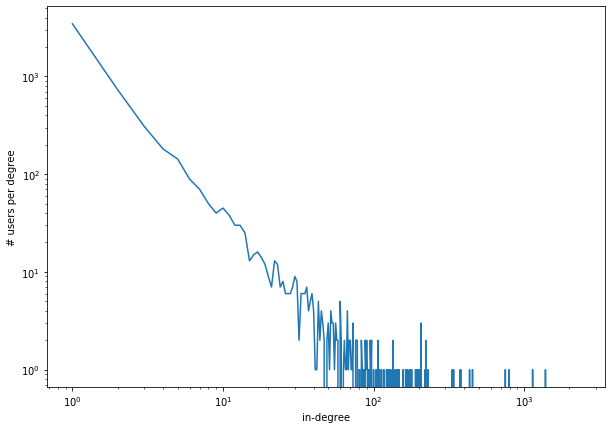

In [109]:
plt.loglog(bins[0:-1],bars)
plt.ylabel('# users per degree')
plt.xlabel('in-degree')

Text(0.5, 0, 'in-degree')

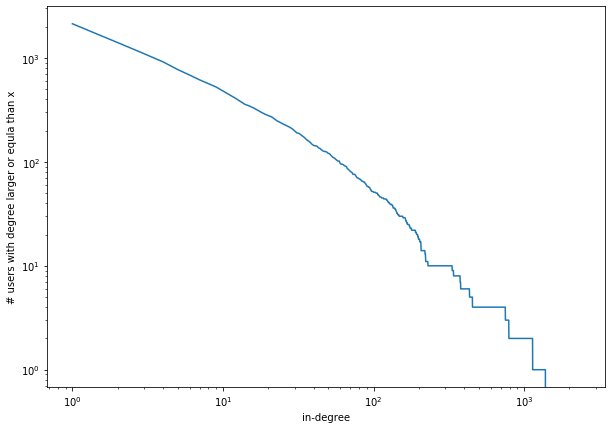

In [110]:
plt.loglog(bins[0:-1],sum(bars)-np.cumsum(bars))
plt.ylabel('# users with degree larger or equla than x')
plt.xlabel('in-degree')

In [93]:
fit = pl.Fit(a)

Calculating best minimal value for power law fit


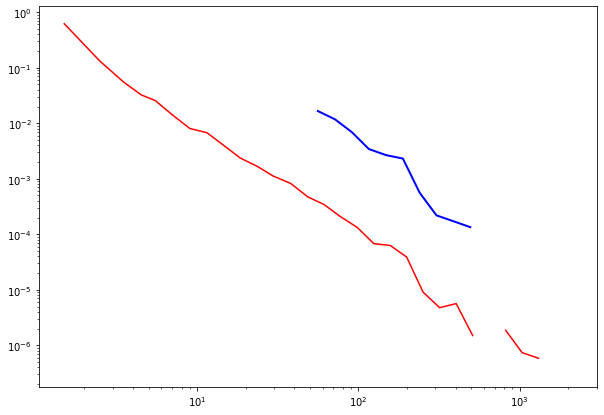

In [94]:
pl.plot_pdf(a, color='r')
fig2=fit.plot_pdf(color='b',linewidth=2)

Text(0.5, 0, 'in-degree')

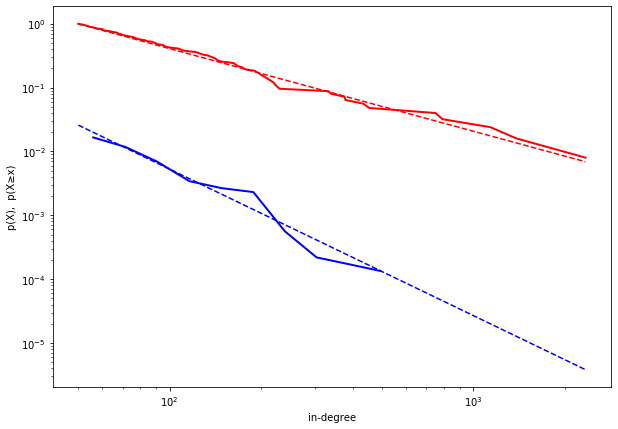

In [95]:
#comparison of data and Pl-fits of pdf (blue) and ccdf (red)"
figCCDF = fit.plot_pdf(color='b', linewidth=2)
fit.power_law.plot_pdf(color='b', linestyle='--', ax=figCCDF)
fit.plot_ccdf(color='r', linewidth=2, ax=figCCDF)
fit.power_law.plot_ccdf(color='r', linestyle='--', ax=figCCDF)
####
figCCDF.set_ylabel(u"p(X),  p(X≥x)")
figCCDF.set_xlabel(r"in-degree")

### Problem 4

#### Transform directed graph into undirected

In [98]:
graph_und = snap.ConvertGraph(snap.PUNGraph, ment_graph)
snap.PrintInfo(graph_und, "Grammys UN Stats", "grammysUN-info.txt",  False)

f = open('grammysUN-info.txt', 'r')
file_contents = f.read()
print (file_contents)
f.close()

Grammys UN Stats:
  Nodes:                    32122
  Edges:                    37460
  Zero Deg Nodes:           0
  Zero InDeg Nodes:         0
  Zero OutDeg Nodes:        0
  NonZero In-Out Deg Nodes: 32122
  Unique directed edges:    74801
  Unique undirected edges:  37460
  Self Edges:               119
  BiDir Edges:              74801
  Closed triangles:         1495
  Open triangles:           6239248
  Frac. of closed triads:   0.000240
  Connected component size: 0.795561
  Strong conn. comp. size:  0.795561
  Approx. full diameter:    20
  90% effective diameter:  8.634149



#### Preferential Attachment

In [99]:
AverageDegree = graph_und.GetEdges()/graph_und.GetNodes() #truncated average degree
AverageDegreeF = graph_und.GetEdges()/float(graph_und.GetNodes())
print(AverageDegree)
print(AverageDegreeF)

# Preferential Attachment
Rnd = snap.TRnd()
G5PRefAttach = snap.GenPrefAttach(graph_und.GetNodes(), int(AverageDegree), Rnd)
snap.PrintInfo(G5PRefAttach, "Grammys PA Stats", "grammysPA-info.txt",  False)

f = open('grammysPA-info.txt', 'r')
file_contents = f.read()
print (file_contents)
f.close()

1.1661789427806488
1.1661789427806488
Grammys PA Stats:
  Nodes:                    32122
  Edges:                    32121
  Zero Deg Nodes:           0
  Zero InDeg Nodes:         0
  Zero OutDeg Nodes:        0
  NonZero In-Out Deg Nodes: 32122
  Unique directed edges:    64242
  Unique undirected edges:  32121
  Self Edges:               0
  BiDir Edges:              64242
  Closed triangles:         0
  Open triangles:           281131
  Frac. of closed triads:   0.000000
  Connected component size: 1.000000
  Strong conn. comp. size:  1.000000
  Approx. full diameter:    27
  90% effective diameter:  13.939056



#### Configuration model

In [100]:
# Configuration Model
G5UnDegSeqV = snap.TIntV()
snap.GetDegSeqV(graph_und, G5UnDegSeqV)

Rnd = snap.TRnd()
G5ConfModel = snap.GenConfModel(G5UnDegSeqV, Rnd)
snap.PrintInfo(G5ConfModel, "Grammys ConfModel Stats", "grammys_ConfModel-info.txt",  False)

f = open('grammys_ConfModel-info.txt', 'r')
file_contents = f.read()
print (file_contents)
f.close()

Grammys ConfModel Stats:
  Nodes:                    32122
  Edges:                    35936
  Zero Deg Nodes:           0
  Zero InDeg Nodes:         0
  Zero OutDeg Nodes:        0
  NonZero In-Out Deg Nodes: 32122
  Unique directed edges:    71872
  Unique undirected edges:  35936
  Self Edges:               0
  BiDir Edges:              71872
  Closed triangles:         11509
  Open triangles:           3899647
  Frac. of closed triads:   0.002943
  Connected component size: 0.700890
  Strong conn. comp. size:  0.700890
  Approx. full diameter:    14
  90% effective diameter:  5.230029



#### Node rewiring

In [101]:
# Node Rewiring
Rnd = snap.TRnd()
G5RW = snap.GenRewire(graph_und, 1000, Rnd)

snap.PrintInfo(G5RW, "Grammys Rewire Stats", "Grammys_Rewire-info.txt",  False)

f = open('Grammys_Rewire-info.txt', 'r')
file_contents = f.read()
print (file_contents)
f.close()

Grammys Rewire Stats:
  Nodes:                    32122
  Edges:                    37341
  Zero Deg Nodes:           36
  Zero InDeg Nodes:         36
  Zero OutDeg Nodes:        36
  NonZero In-Out Deg Nodes: 32086
  Unique directed edges:    74682
  Unique undirected edges:  37341
  Self Edges:               0
  BiDir Edges:              74682
  Closed triangles:         21931
  Open triangles:           6177164
  Frac. of closed triads:   0.003538
  Connected component size: 0.684360
  Strong conn. comp. size:  0.684360
  Approx. full diameter:    12
  90% effective diameter:  4.863549



#### Erdos-Renyi random graph

In [102]:
G5ER = snap.GenRndGnm(snap.PNGraph, graph_und.GetNodes(), graph_und.GetEdges())
snap.PrintInfo(G5ER, "Grammys Random Stats", "grammys_Random-info.txt",  False)

f = open('grammys_Random-info.txt', 'r')
file_contents = f.read()
print (file_contents)
f.close()

Grammys Random Stats: Directed
  Nodes:                    32122
  Edges:                    37460
  Zero Deg Nodes:           3133
  Zero InDeg Nodes:         9993
  Zero OutDeg Nodes:        10037
  NonZero In-Out Deg Nodes: 15225
  Unique directed edges:    37460
  Unique undirected edges:  37458
  Self Edges:               0
  BiDir Edges:              4
  Closed triangles:         3
  Open triangles:           87503
  Frac. of closed triads:   0.000034
  Connected component size: 0.868097
  Strong conn. comp. size:  0.069018
  Approx. full diameter:    25
  90% effective diameter:  14.153827

